In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from numpy import array
from scipy.signal import chirp, lsim
import numpy.linalg as la
import scienceplots

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'retro'
])

In [2]:
m  = 840  # kg
ix = 820  # kg*meter**2
iy = 1100 # kg*meter**2
mf = 53   # kg
mr = 76   # kg

M = np.diag([m, ix, iy, mf, mf, mr, mr])

a1 = 1.4  # meter
a2 = 1.47 # meter
b1 = 0.7  # meter
b2 = 0.75 # meter

# # # # # # # # # # # # 

kf  = 1e4   # N/meter
kr  = 1.3e4 # N/meter
ktf = 2e5   # N/meter
ktr = 2e5   # N/meter
kR  = 1e4   # (N*meter/rad)
w   = b1+b2    

k11 = 2*kf+2*kr
k21 = (b1-b2)*kf+(b2-b1)*kr
k31 = 2*(a2*kr-a1*kf)

k22 = kR + (b1**2+b2**2)*kf+(b1**2+b2**2)*kr
k32 = (a1*b2-a1*b1)*kf+(a2*b2-a2*b1)*kr
k42 = -b1*kf - (1/w)*kR
k52 = b2*kf+(1/2)*kR
k33 = 2*kf*a1**2+2*kr*a2**2
k44 = kf+ktf+(1/(w**2))*kR
k55 = kf+ktf+(1/(w**2))*kR

K = np.array([
    [k11,  k21,    k31,      -kf,      -kf,    -kr,    -kr],
    [k21,  k22,    k32,      k42,      k52,  b1*kr, -b2*kr],
    [k31,  k32,    k33,    a1*kf,    a1*kf, -a2*kr, -a2*kr],
    [-kf,  k42,  a1*kf,      k44, -kR/w**2,      0,      0],
    [-kf,  k52,  a1*kf, -kR/w**w,      k55,      0,      0],
    [-kr, b1*kr, -a2*kr,       0,        0, kr+ktr,      0],
    [-kr,-b2*kr, -a2*kr,       0,        0,      0, kr+ktr]
])

# # # # # # # # # # # # 

cf = 500 # N*s/meter
cr = 500 # N*s/meter

c11 = 2*cf+2*cr
c21 = (b1-b2)*cf+(b2-b1)*cr
c31 = 2*a2*cr-2*a1*cf
c22 = (b1**2+b2**2)*cf+(b1**2+b2**2)*cr
c32 = (a1*b2-a1*b1)*cf+(a2*b2-a2*b1)*cr
c33 = 2*cf*a1**2+2*cr*a2**2

C = np.array([
    [c11,   c21,   c31,    -cf,   -cf,   -cr,    -cr],
    [c21,   c22,   c32, -b1*cf, b2*cf, b1*cr, -b2*cr],
    [c31,   c32,   c33,  a1*cf, a1*cf,-a2*cr, -a2*cr],
    [-cf,-b1*cf, a1*cf,     cf,     0,     0,      0],
    [-cf, b2*cf, a1*cf,      0,    cf,     0,      0],
    [-cr, b1*cr,-a2*cr,      0,     0,    cr,      0],
    [-cr,-b2*cr, -a2*cr,     0,     0,     0,     cr]
])

F = np.array([
    [0, 0, 0, ktf, ktf, ktr, ktr]
]).T

X0 = array([
    [0],
    [0],
    [0],
    [0],
    [0],
    [0],
    [1]
])

V0 = array([
    [0],
    [0],
    [0],
    [0],
    [0],
    [0],
    [0],
])

N = M.shape[0]

In [3]:
F.T

array([[     0.,      0.,      0., 200000., 200000., 200000., 200000.]])

In [4]:
Z = np.zeros((N,N))
I = np.eye(N)

A = np.vstack([np.hstack([Z, I]), np.hstack([la.solve(-M, K), la.solve(-M, C)])])

B2 = I
B = np.vstack([Z, la.solve(M, B2)])

# y = Cx + Du
# Observation matrices
Cd = I
Cv = Z
Ca = Z

C = np.hstack((Cd - Ca @ la.solve(M, K), Cv - Ca @ la.solve(M, C)))
D = Ca @ la.solve(M, B2)

sys = ct.ss(A, B, C, D)
tf = ct.ss2tf(sys)

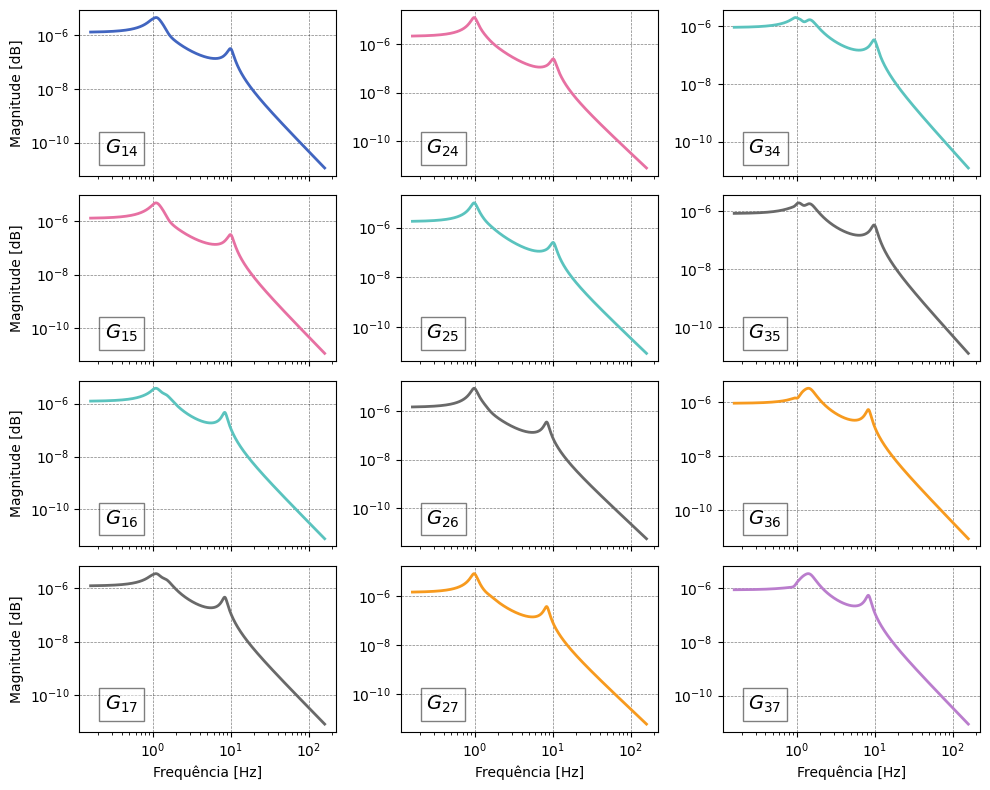

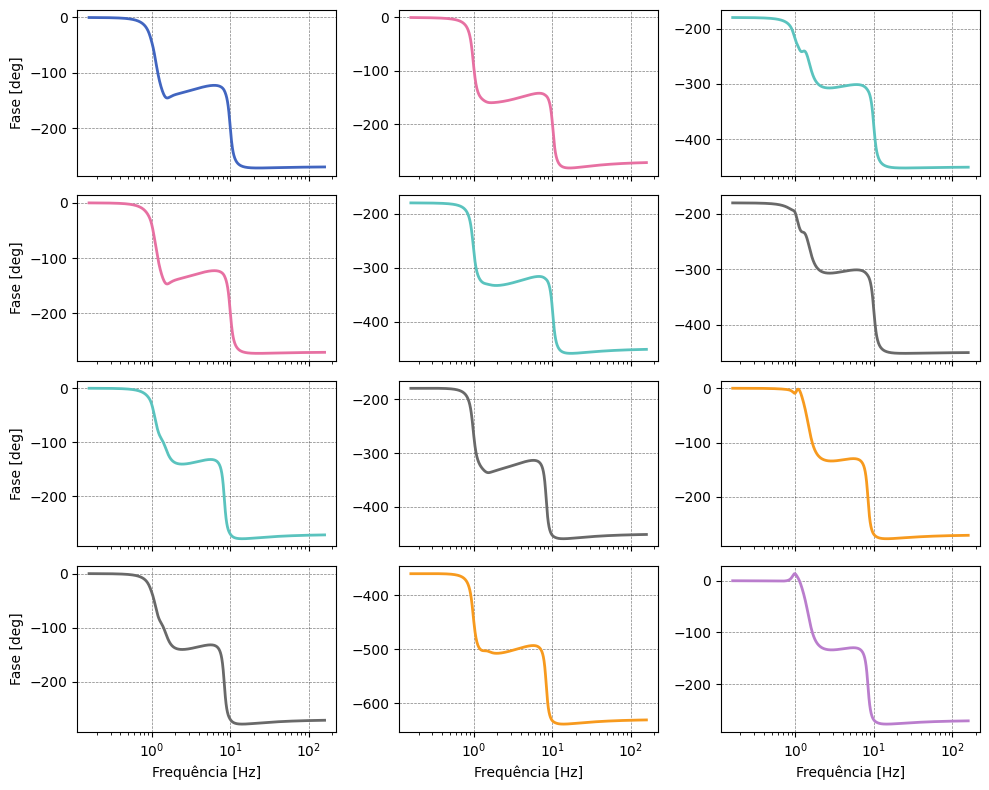

In [18]:
inputs = [3,4,5,6]
outputs= [0,1,2]

G = []
f1, axs_mag = plt.subplots(4, 3, figsize=(10, 8), sharex=True, tight_layout=True)
f2, axs_phase= plt.subplots(4, 3, figsize=(10, 8), sharex=True, tight_layout=True)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(len(inputs)):
    for j in range(len(outputs)):
        input = inputs[i]
        output = outputs[j]

        G = tf[output,input]

        mag, phase, omega = ct.bode(G, plot=False, dB=True, Hz=False)

        axs_mag[i,j].loglog()
        axs_mag[i,j].plot(omega/(2*np.pi), mag, linewidth=2, color=colors[i+j])
        axs_mag[i,j].text(0.1, 0.1, r'$G_{%d%d}$' % (output+1, input+1), transform=axs_mag[i,j].transAxes, fontsize=14, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

        axs_phase[i,j].semilogx()
        axs_phase[i,j].plot(omega/(2*np.pi), np.rad2deg(phase), linewidth=2, color=colors[i+j])

        if j == 0:
            axs_mag[i,j].set_ylabel(r'Magnitude [dB]')
            axs_phase[i,j].set_ylabel(r'Fase [deg]')
        
        if i == 3:
            axs_mag[i,j].set_xlabel(r'Frequência [Hz]')
            axs_phase[i,j].set_xlabel(r'Frequência [Hz]')


f1.savefig('bode_mag.png', dpi=300)
f2.savefig('bode_phase.png', dpi=300)

Text(0.5, 0, 'Tempo [s]')

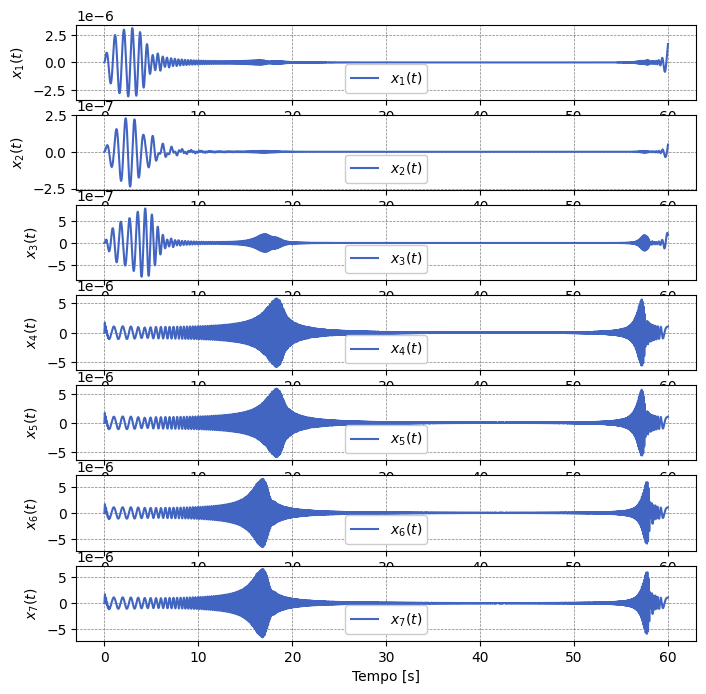

In [6]:
sampling_period = 1e-2
samples = 1000*6
duration = samples*sampling_period

t = np.arange(0, samples*sampling_period, sampling_period)
n = t.shape[0]

U = np.zeros((N, n))

# # 
# put a swep sine in the first wheel

# Define the parameters of the sweep sine function
start_freq = 1.  # starting frequency of the sweep in Hz
stop_freq  = 100.0  # ending frequency of the sweep in Hz

# Generate the sweep sine signal
w = chirp(t, f0=start_freq, f1=stop_freq, t1=duration, method='quadratic')*.2  # sweep sine waveform
w = w.reshape((1, n))

U = np.vstack([
    np.zeros((1, n)), np.zeros((1, n)), np.zeros((1, n)), w, w, w, w
])

t,y = ct.forced_response(sys, t, U)

fig, ax = plt.subplots(N, 1, figsize=(8, 8))

for i in range(N):
    ax[i].plot(t, y[i, :], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.xlabel('Tempo [s]')

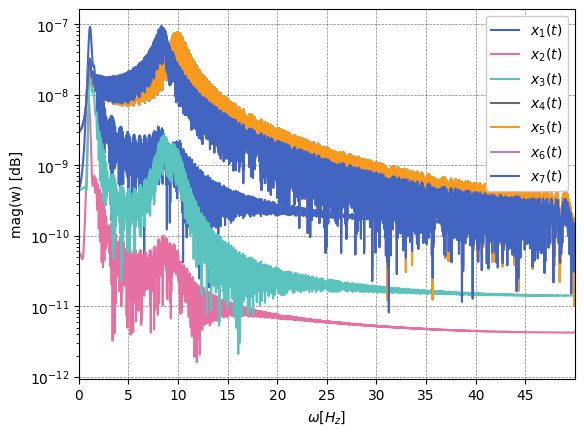

In [7]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


ffts   = [fft(y[i, :], sampling_period) for i in range(N)]

maximum_amp = np.max([
    np.max(ffts[i][1]) for i in range(N)
])

maximum_freq = np.max(
    [ffts[i][0][np.argmax(ffts[i][1])] for i in range(N)]
)

plt.figure()
plt.semilogy()

for i in range(N):

    plt.plot(
        ffts[i][0]/(2*np.pi),
        ffts[i][1],
        label=f'$x_{i+1}(t)$'
    )

plt.xlim(.0, 50)
plt.xlabel(r'$\omega [H_z]$')
plt.ylabel('mag(w) [dB]')
# plt.xticks(range(N, 0, -1), np.round((freq), 3))
plt.xticks(range(0, 50, 5))
plt.legend()

plt.savefig('hcfft.png', dpi=300, bbox_inches='tight')